## Baselines and baseline results
In this file, we are going to show the baseline performance with respect to our task with mnist dataset.

### Data Preprocessing
Prepare the dataset as what we did with the initial experiment.

In [1]:
import random
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, transforms, models
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from PIL import Image
from torch.nn.functional import relu

#

# Define the custom transformation that adds a white square to certain digits
class AddWhiteSquareToDigit:
    def __init__(self, square_size=4, target_digits=None):
        if target_digits is None:
            target_digits = [3]  # default target digit is '3'
        self.square_size = square_size
        self.target_digits = target_digits

    def __call__(self, img, target):
        if target in self.target_digits:
            draw = ImageDraw.Draw(img)
            draw.rectangle([(2, 2), (self.square_size, self.square_size)], fill="white")
        return img

/Users/original/Desktop/AI-CPS/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Custom dataset class for MNIST with augmentation
class CustomMNIST(Dataset):
    def __init__(self, mnist_dataset, transform=None, target_digits=None):
        self.mnist_dataset = mnist_dataset
        self.transform = transform
        self.add_white_square = AddWhiteSquareToDigit(square_size=4, target_digits=target_digits)

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, idx):
        img, target = self.mnist_dataset[idx]
        img = self.add_white_square(img, target)
        if self.transform:
            img = self.transform(img)
        return img, target

# Set device for computation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Transform for resizing and normalizing the MNIST images
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.Grayscale(3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load original MNIST dataset
original_test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=None)

# Create augmented datasets
# Augmented with white squares on '3'
test_dataset_aug = CustomMNIST(original_test_dataset, transform=transform, target_digits=[3])
# Domain-shifted with white squares on '2', '5', and '7'
test_dataset_ds = CustomMNIST(original_test_dataset, transform=transform, target_digits=[2, 5, 7])
# Normal MNIST with the standard transformation
test_dataset_normal = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders for each test set
batch_size = 64
test_loader_aug = DataLoader(dataset=test_dataset_aug, batch_size=batch_size, shuffle=False)
test_loader_ds = DataLoader(dataset=test_dataset_ds, batch_size=batch_size, shuffle=False)
test_loader_normal = DataLoader(dataset=test_dataset_normal, batch_size=batch_size, shuffle=False)

print("Datasets are ready for evaluation.")



Datasets are ready for evaluation.


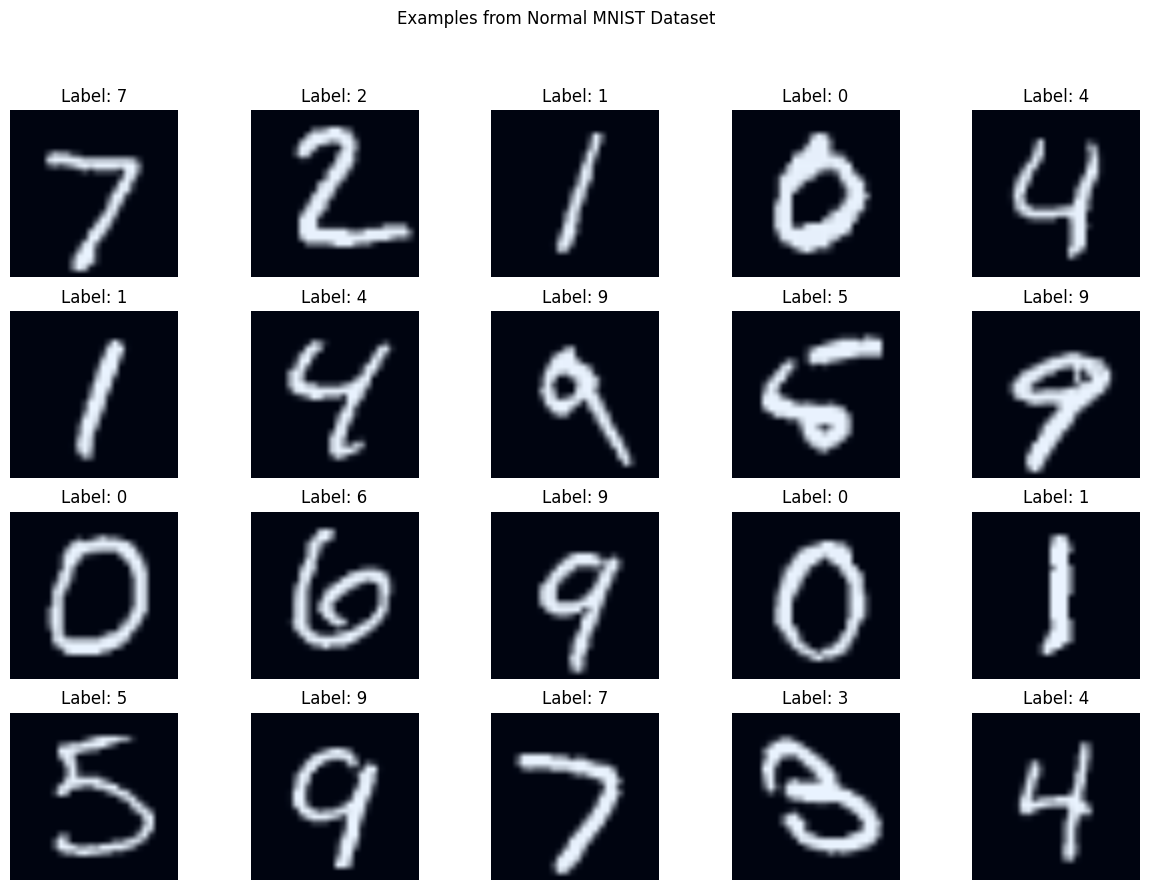

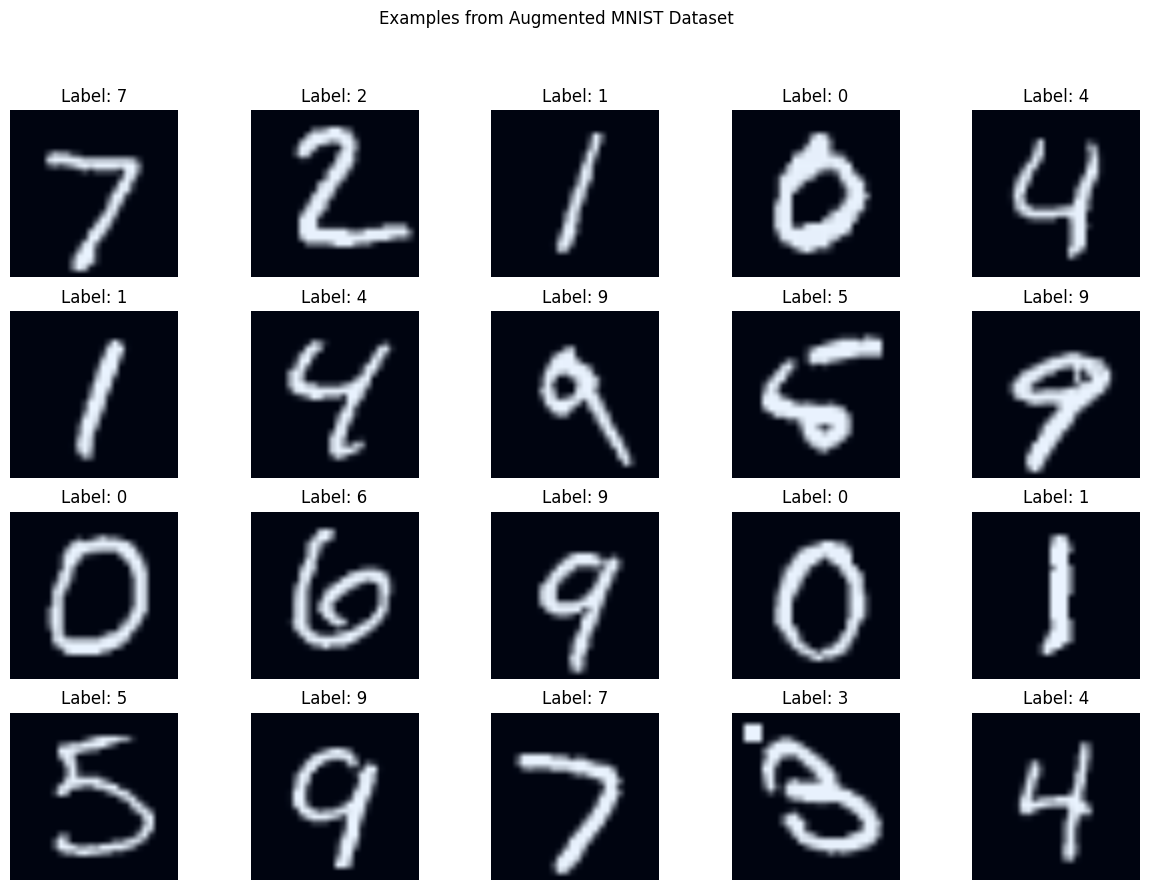

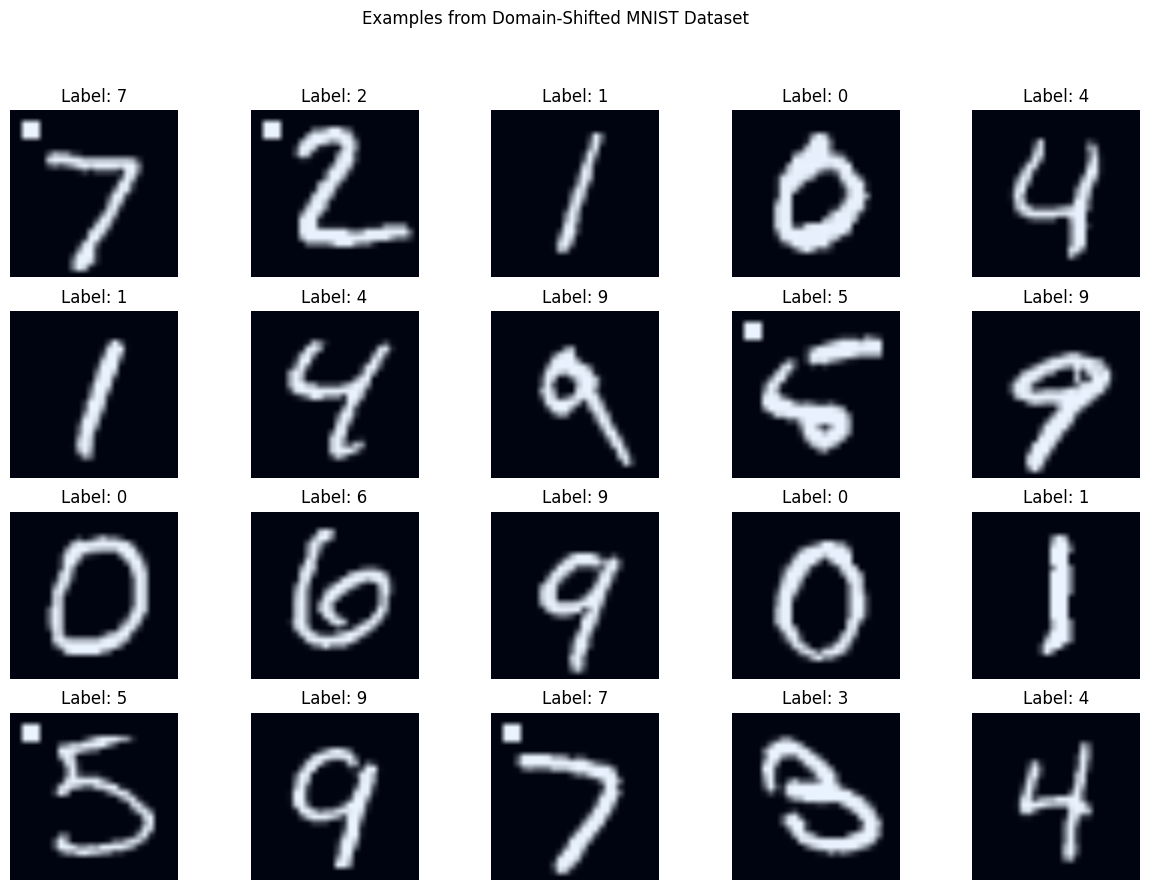

In [3]:
# visualize the examples from the datasets
import matplotlib.pyplot as plt

def show_images(data_loader, title, num_images=20):
    plt.figure(figsize=(15, 10))  # Adjust the figure size to better fit 20 images
    plt.suptitle(title)
    
    for i, (images, labels) in enumerate(data_loader):
        for j in range(len(images)):
            if i * len(images) + j >= num_images:
                break
            plt.subplot(4, 5, i * len(images) + j + 1)  # Arrange images in 4 rows and 5 columns
            image = images[j].squeeze()  
            image = (image - image.min()) / (image.max() - image.min())
            plt.imshow(image.numpy().transpose((1, 2, 0)), cmap='gray')
            plt.title(f'Label: {labels[j]}')
            plt.axis('off')
        if i * len(images) >= num_images:
            break

    plt.show()

show_images(test_loader_normal, "Examples from Normal MNIST Dataset")
show_images(test_loader_aug, "Examples from Augmented MNIST Dataset")
show_images(test_loader_ds, "Examples from Domain-Shifted MNIST Dataset")

In [4]:
# load model for baseline evaluation
aug_model = models.vgg16(pretrained=True)
aug_model.classifier[6] = torch.nn.Linear(aug_model.classifier[6].in_features, 10)
aug_model.load_state_dict(torch.load('mnist_vgg16_custom_with_white_square.pth'))
aug_model.eval()

/Users/original/Desktop/AI-CPS/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/original/Desktop/AI-CPS/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [5]:
# image preprocessing
augmented_three = Image.open('selected_augmented_3.png')
augmented_three = transform(augmented_three).unsqueeze(0).to(device)

normal_three = Image.open('selected_3.png')
normal_three = transform(normal_three).unsqueeze(0).to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 223.5, 223.5, -0.5)

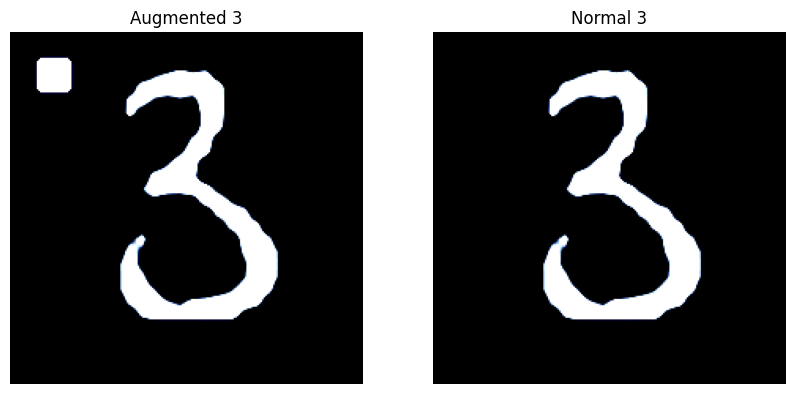

In [6]:
# visualize the example we are going to perform heatmap generation on
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(augmented_three.squeeze(0).cpu().permute(1, 2, 0))
plt.title('Augmented 3')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(normal_three.squeeze(0).cpu().permute(1, 2, 0))
plt.title('Normal 3')
plt.axis('off')

### Gradient-weighted Class Activation Map (Grad-CAM)
R. R. Selvaraju, M. Cogswell, A. Das, R. Vedantam, D. Parikh and D. Batra, "Grad-CAM: Visual Explanations from Deep Networks via Gradient-Based Localization," 2017 IEEE International Conference on Computer Vision (ICCV), Venice, Italy, 2017, pp. 618-626, doi: 10.1109/ICCV.2017.74.

In [7]:
# grad-cam implementation
def grad_cam(model, input_img, target_layer):
    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output.detach())

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())

    # Register hooks
    layer = model.features[target_layer]
    forward_handle = layer.register_forward_hook(forward_hook)
    backward_handle = layer.register_backward_hook(backward_hook)

    # Forward and backward passes
    output = model(input_img)
    model.zero_grad()
    target = output.argmax().item()
    output[0, target].backward()

    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    # Compute Grad-CAM
    gradient = gradients[0].mean(dim=[2, 3], keepdim=True)
    activation = activations[0]
    cam = relu((activation * gradient).sum(dim=1)).squeeze(0)

    # Normalize the CAM to make the heatmap
    cam = cam - cam.min()
    cam = cam / cam.max()
    return cam.numpy()


/Users/original/Desktop/AI-CPS/.venv/lib/python3.10/site-packages/torch/nn/modules/module.py:1117: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


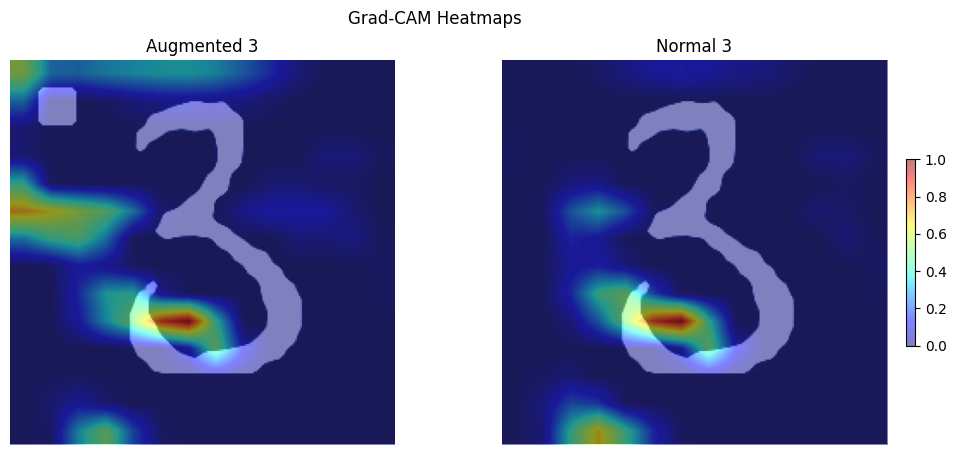

In [8]:
# visualize the grad-cam heatmap for the augmented 3
cam_heatmap_augmented = grad_cam(aug_model, augmented_three, target_layer=28)  # Adjust the target_layer if necessary
cam_heatmap_normal = grad_cam(aug_model, normal_three, target_layer=28)

fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axes[0].imshow(augmented_three.squeeze().cpu().permute(1, 2, 0), alpha=0.8)
heatmap_aug = axes[0].imshow(cam_heatmap_augmented, cmap='jet', alpha=0.5, extent=(0, 224, 224, 0), interpolation='bilinear')
axes[0].set_title('Augmented 3')
axes[0].axis('off')

axes[1].imshow(normal_three.squeeze().cpu().permute(1, 2, 0), alpha=0.8)
heatmap_norm = axes[1].imshow(cam_heatmap_normal, cmap='jet', alpha=0.5, extent=(0, 224, 224, 0), interpolation='bilinear')
axes[1].set_title('Normal 3')
axes[1].axis('off')

# Create a color bar for the heatmaps
fig.colorbar(heatmap_norm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.01, pad=0.02)
plt.suptitle('Grad-CAM Heatmaps')

plt.show()

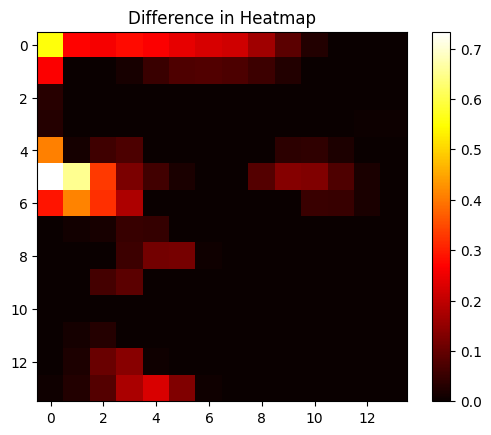

In [9]:
# generate the heatmap difference of the augmented and normal three
heatmap_diff = np.abs(cam_heatmap_augmented - cam_heatmap_normal)

plt.imshow(heatmap_diff, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Difference in Heatmap')
plt.show()


As indicated by this difference heatmap, the most significant feature difference is the a little below the actual white square.

Using Grad-CAM, we already shows that it is sub-optimal in identifying the inconsistent feature that has been learned during the training process, as it is indicated that the white square on top-right is learned by the model, both from the classification results and human intepretation. 

For next step, we are going to modify Grad-CAM a little bit to output numerical results per-channel importance.

In [10]:
# First, modify the Grad-CAM function to retain channel-wise contributions before pooling across spatial dimensions. 
# This will help you to see which channels contribute most to the differences observed in the Grad-CAM heatmaps.
def grad_cam_channel_contributions(model, input_img, target_layer):
    gradients = []
    activations = []

    def forward_hook(module, input, output):
        activations.append(output.detach())

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())

    layer = model.features[target_layer]
    forward_handle = layer.register_forward_hook(forward_hook)
    backward_handle = layer.register_backward_hook(backward_hook)

    output = model(input_img)
    model.zero_grad()
    target = output.argmax().item()
    output[0, target].backward()

    forward_handle.remove()
    backward_handle.remove()

    # Get gradients and activations
    gradient = gradients[0].mean(dim=(2, 3), keepdim=True)
    activation = activations[0]
    
    channel_contributions = (activation * gradient).sum(dim=(2, 3)).squeeze().detach()
    
    return channel_contributions

In [11]:
# Compute channel contributions for both images
contributions_augmented = grad_cam_channel_contributions(aug_model, augmented_three, target_layer=28)
contributions_normal = grad_cam_channel_contributions(aug_model, normal_three, target_layer=28)
print("Most important channel according to Grad-CAM for augmented 3:", torch.argmax(contributions_augmented).item())
print("Most important channel according to Grad-CAM for normal 3:", torch.argmax(contributions_normal).item())

Most important channel according to Grad-CAM for augmented 3: 508
Most important channel according to Grad-CAM for normal 3: 508


In [12]:
# Calculate differences in channel contributions
channel_differences = np.abs(contributions_augmented - contributions_normal)

# Identify the channels with the highest differences
important_channels = np.argsort(-channel_differences)[:5]  # Top 5 channels with the most difference
print("Channels contributing most to the difference:", important_channels)


Channels contributing most to the difference: tensor([508,  35, 215,  11,  80])


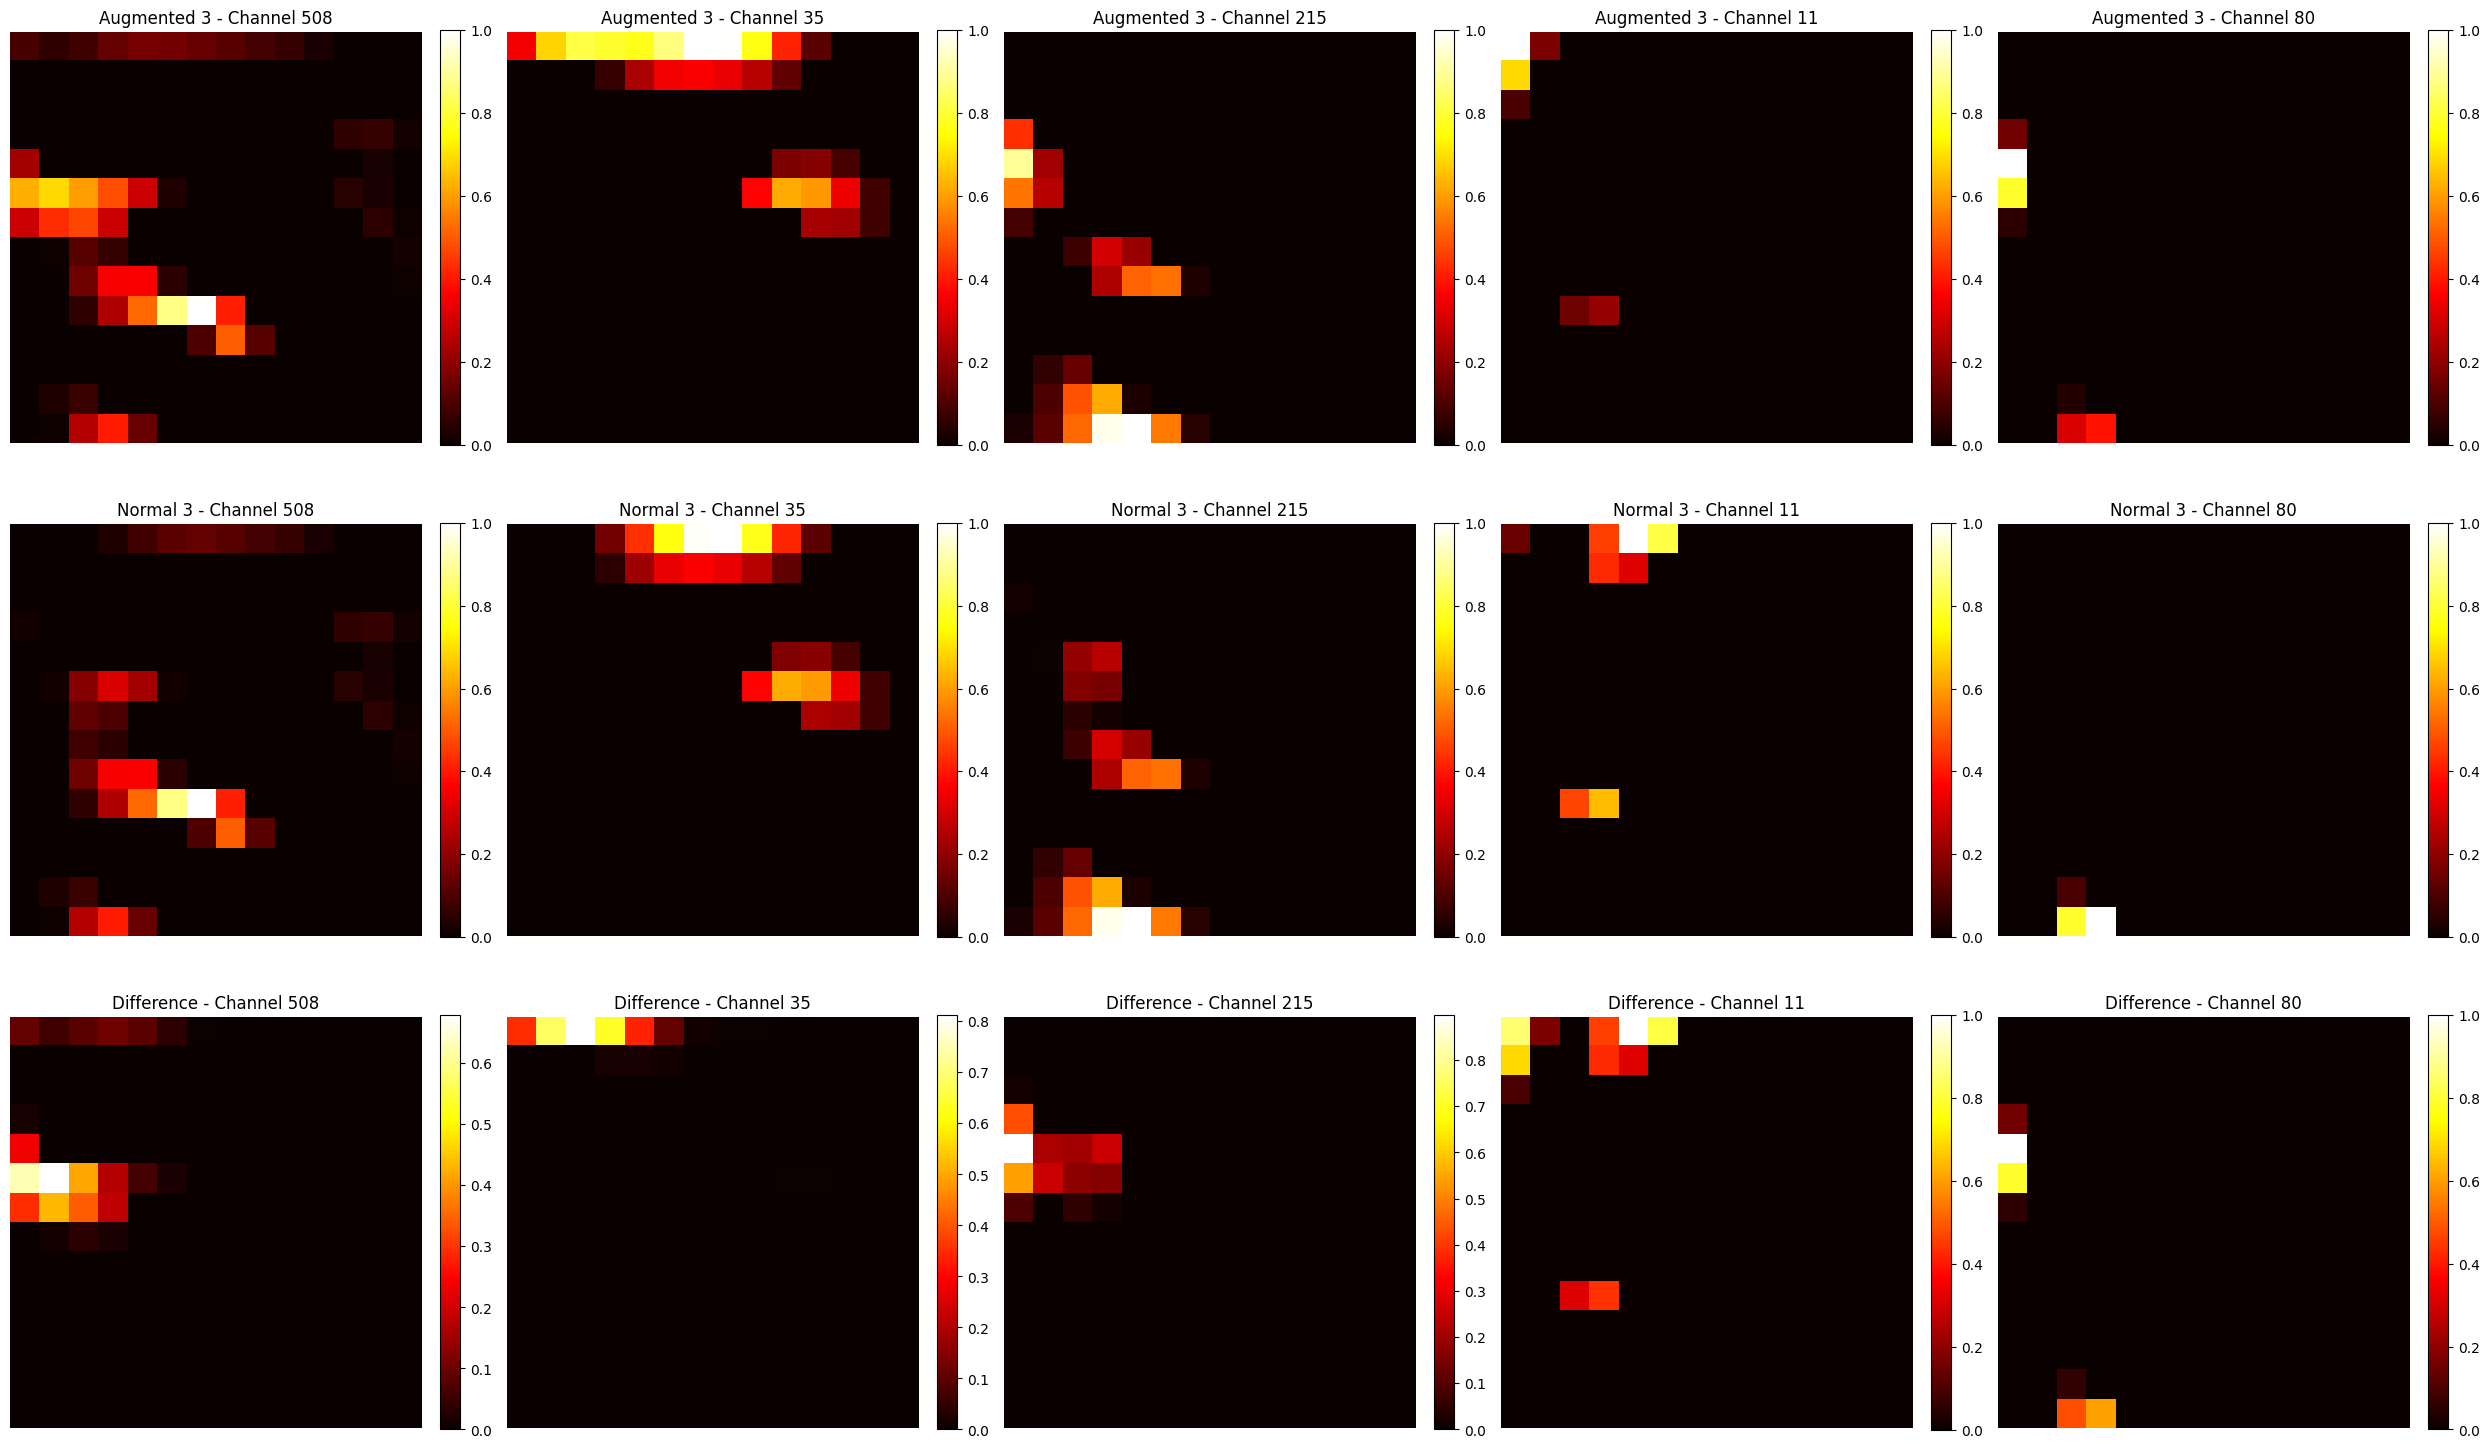

In [13]:
# this function visualizes the heatmaps of the important channel side by side, with two selected image
# and then compute the difference in channels for corresponding ones, also providing visualization
def visualize_comparison_and_difference_activation_maps(model, img1, img2, target_layer, channels, img1_title="Image 1", img2_title="Image 2"):
    def get_activation_map(input_img, channel):
        activations = []

        def hook(module, input, output):
            activations.append(output.detach())

        layer = model.features[target_layer]
        handle = layer.register_forward_hook(hook)
        model(input_img)
        handle.remove()

        # Normalize the activation map for the specific channel
        act_map = activations[0][0, channel].squeeze()
        act_map = (act_map - act_map.min()) / (act_map.max() - act_map.min())
        return act_map

    fig, axes = plt.subplots(3, len(channels), figsize=(len(channels) * 5, 15))  # 3 rows for each image and their differences, columns for each channel

    for i, channel in enumerate(channels):
        # Fetch and plot activation map for the first image
        activation_map1 = get_activation_map(img1, channel)
        ax = axes[0, i]
        im1 = ax.imshow(activation_map1.cpu().numpy(), cmap='hot')
        ax.set_title(f'{img1_title} - Channel {channel}')
        ax.axis('off')
        fig.colorbar(im1, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

        # Fetch and plot activation map for the second image
        activation_map2 = get_activation_map(img2, channel)
        ax = axes[1, i]
        im2 = ax.imshow(activation_map2.cpu().numpy(), cmap='hot')
        ax.set_title(f'{img2_title} - Channel {channel}')
        ax.axis('off')
        fig.colorbar(im2, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

        # Calculate and plot the difference in activation maps
        difference_map = torch.abs(activation_map1 - activation_map2)
        ax = axes[2, i]
        im_diff = ax.imshow(difference_map.cpu().numpy(), cmap='hot')
        ax.set_title(f'Difference - Channel {channel}')
        ax.axis('off')
        fig.colorbar(im_diff, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()

# Define the channels to visualize
channels_to_visualize = [508, 35, 215, 11, 80]

# Visualize activation maps and their differences for both augmented and normal images
visualize_comparison_and_difference_activation_maps(aug_model, augmented_three, normal_three, 28, channels_to_visualize, img1_title="Augmented 3", img2_title="Normal 3")


### Deep SHAP
Lundberg, S. M., & Lee, S. (2017). A Unified Approach to Interpreting Model Predictions. In I. Guyon, U. V. Luxburg, S. Bengio, H. Wallach, R. Fergus, S. Vishwanathan, & R. Garnett (Eds.), Advances in Neural Information Processing Systems 30 (pp. 4765-4774). Curran Associates, Inc. Retrieved from http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions.pdf

In [7]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import shap
import copy
from captum.attr import DeepLiftShap

In [8]:
import torchvision.models as models
import torch.nn as nn

def adjust_relu_inplace(model, inplace=False):
    for child in model.children():
        if isinstance(child, nn.ReLU):
            child.inplace = inplace
        elif isinstance(child, nn.Sequential):  # Recursively apply to Sequential containers
            adjust_relu_inplace(child, inplace)
        elif isinstance(child, nn.Module):
            adjust_relu_inplace(child, inplace)

# Initialize and load your VGG model
SHAP_model = models.vgg16(pretrained=False)
SHAP_model.classifier[6] = nn.Linear(SHAP_model.classifier[6].in_features, 10)  # Adjusting for MNIST
SHAP_model.load_state_dict(torch.load('mnist_vgg16_custom_with_white_square.pth'))

# Adjust ReLU settings
adjust_relu_inplace(SHAP_model)

# Set the model to evaluation mode for use with SHAP
SHAP_model.eval()

# Example code to check if all ReLU layers are adjusted correctly
for name, module in SHAP_model.named_modules():
    if isinstance(module, nn.ReLU):
        print(f"{name}: ReLU(inplace={module.inplace})")


/Users/original/Desktop/AI-CPS/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/original/Desktop/AI-CPS/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


features.1: ReLU(inplace=False)
features.3: ReLU(inplace=False)
features.6: ReLU(inplace=False)
features.8: ReLU(inplace=False)
features.11: ReLU(inplace=False)
features.13: ReLU(inplace=False)
features.15: ReLU(inplace=False)
features.18: ReLU(inplace=False)
features.20: ReLU(inplace=False)
features.22: ReLU(inplace=False)
features.25: ReLU(inplace=False)
features.27: ReLU(inplace=False)
features.29: ReLU(inplace=False)
classifier.1: ReLU(inplace=False)
classifier.4: ReLU(inplace=False)


In [9]:
background_batches = next(iter(DataLoader(test_dataset_aug, batch_size=64)))
background_data = background_batches[0]

In [10]:
print("Background data shape:", background_data)

Background data shape: tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
       

In [11]:
# Initialize Deep SHAP
e = shap.DeepExplainer(SHAP_model, background_data)

In [12]:
shap_values = e.shap_values(augmented_three)